# Synchronize Timestamps across multiple CSV files

- truncate leading and trailing timestamps
- uses the lowest resolution timestamp interval from all the CSV files
- for each point at the lowest resolution, find the nearest point in each CSV file and collect them into a new CSV file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
BFG1 = pd.read_csv("LC709203F_5.csv")
BFG2 = pd.read_csv("MAX17043_5.csv")
BFG_arbin = pd.read_csv('BFG_take_2_Channel_2_Wb_1.CSV')

In [3]:
# convert the timestamps to datetime objects
BFG1['Timestamp'] = pd.to_datetime(BFG1['Timestamp'])
BFG2['Timestamp'] = pd.to_datetime(BFG2['Timestamp'])
BFG_arbin['Date_Time'] = pd.to_datetime(BFG_arbin['Date_Time'])
# convert arbin timestamps from EST (-4 at time of recording) to UTC (0) 
if BFG_arbin['Date_Time'].iat[0].tzinfo is None:
    BFG_arbin['Date_Time'] = BFG_arbin['Date_Time'] + datetime.timedelta(hours=4)
    BFG_arbin['Date_Time'] = BFG_arbin['Date_Time'].dt.tz_localize('UTC')
# add decimal seconds to arbin timestamps (arbin timestamps are in whole seconds, but recorded at 2hz)
BFG_arbin['Test_Time(s)'] = BFG_arbin['Test_Time(s)'].astype(float) % 1
BFG_arbin['Date_Time'] = BFG_arbin['Date_Time'] + pd.to_timedelta(BFG_arbin['Test_Time(s)'], unit='s')

# rename relevant columns for comparing to BFG1 and BFG2
BFG_arbin = BFG_arbin.rename(columns={'Date_Time': 'Timestamp', 'Current(A)': 'Current', 'Voltage(V)': 'Voltage'})

# create a dict of the dataframes
dfnames = {'LC709203F': BFG1, 'MAX17043': BFG2, 'Arbin': BFG_arbin}

In [4]:
# truncate database entries that have timestamps that are leading or trailing

# drop datapoints that are outside of the range of the timestamps
first = max([df['Timestamp'].iat[0] for df in dfnames.values()])
last = min([df['Timestamp'].iat[-1] for df in dfnames.values()])
for name, df in dfnames.items():
    df = df.drop(df[(df.Timestamp < first) | (df.Timestamp > last)].index)
    df = df.reset_index(drop=True)
    dfnames[name] = df

In [5]:
# create the output dataset and fill it with data that can be directly compared to the Arbin data
output_df = pd.DataFrame()

# reuse the timestamp column with the lowest resolution column
output_df['Timestamp'] = max(dfnames.values(), key=lambda x: x.Timestamp.diff().mean())['Timestamp']

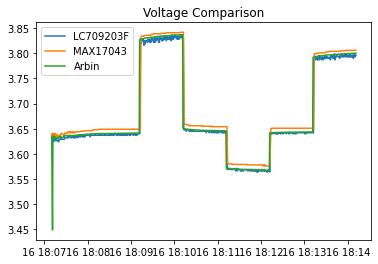

In [6]:
# plot the data

for name, df in dfnames.items():
    plt.plot(df['Timestamp'], df['Voltage'], label=name)
plt.title('Voltage Comparison')
plt.legend()
plt.show()

In [7]:
# convert timestamps to floating values relative to an epoch
epoch = output_df['Timestamp'].iat[0]
output_df['Timestamp'] = (output_df['Timestamp'] - epoch).dt.total_seconds()
print(output_df['Timestamp'])
for name, df in dfnames.items():
    df['Timestamp'] = (df['Timestamp'] - epoch).dt.total_seconds()
    print(name, df.shape[0])

0        0.000000
1        0.466374
2        1.022258
3        1.488395
4        2.028393
          ...    
821    418.979504
822    419.538092
823    420.005279
824    420.562191
825    421.029668
Name: Timestamp, Length: 826, dtype: float64
LC709203F 826
MAX17043 826
Arbin 849


In [8]:
# for each timestamp in the output dataframe, find the index of the closest timestamp in each input dataframe
# WIP: this is not working as expected

indices = {}
for name, df in dfnames.items():
    indices[name] = df['Timestamp'].searchsorted(output_df['Timestamp'])
    print(name, indices[name].shape[0])

LC709203F 826
MAX17043 826
Arbin 826
